In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
import ufss

In [37]:
site_energies = [0,0]
site_couplings = [0.5]
dipoles = [[1,0,0],
           [0,1,0]]
trunc_size = 3
d = 0.1
open_folder = 'Redfield_test'
os.makedirs(open_folder,exist_ok=True)

site_bath = {'cutoff_frequency':1,
               'coupling':0.05,
               'temperature':1,
               'cutoff_function':'lorentz-drude',
                'spectrum_type':'ohmic'}

vibration_bath = site_bath # use same bath for sites and vibrations

relax_bath = {'dephasing_rate':0.1, # additonal "pure" dephasing
              'relaxation_rate':0.05,
               'temperature':1,
                'spectrum_type':'white-noise'}


Redfield_bath = {'secular':False,
        'site_bath':site_bath,
        'vibration_bath':vibration_bath}#,
        #'site_internal_conversion_bath':relax_bath} #include if you wish to model inter-manifold relaxation

vibrations = [{'displacement':d,'site_label':0,'omega_g':1},
              {'displacement':d,'site_label':1,'omega_g':1.0001}]

params = {
    'site_energies':site_energies,
    'site_couplings':site_couplings,
    'dipoles':dipoles,
    'truncation_size':trunc_size,
    'vibrations':vibrations,
    'bath':Redfield_bath}

with open(os.path.join(open_folder,'simple_params.yaml'),'w+') as new_file:
    yaml.dump(params,new_file)

ufss.HLG.run(open_folder)

In [38]:
tdpe = ufss.DensityMatrices(os.path.join(open_folder,'open'),detection_type='complex_polarization')
# set electric field shape
M = 41 #should be odd
Delta = 10
t = np.linspace(-Delta/2,Delta/2,num=M)
pulse_shape = ufss.efield_shapes.gaussian
sigma = 1
ef = pulse_shape(t,sigma)
tdpe.set_efields([t,t,t,t],[ef,ef,ef,ef],[0,0,0,0],[(0,1),(1,0),(1,0)])
tdpe.set_polarization_sequence(['x','x','x','x'])
tdpe.set_t(0.2,dt=0.5)

tau = tdpe.t[tdpe.t.size//2:]
T = np.arange(20)

tdpe.set_pulse_delays([tau,T])

In [39]:
signal = tdpe.calculate_signal_all_delays()
tdpe.save('UF2_2DPE',['tau','T'])

In [40]:
tdpe.calculation_time

24.65311312675476

In [41]:
wtau, ft_signal = ufss.signals.SignalProcessing.ft1D(tau,signal,axis=0)

In [42]:
ft_signal.shape

(69, 20, 137)

2DPE signal at T = 0.00 $\omega_0^{-1}$


<IPython.core.display.Javascript object>


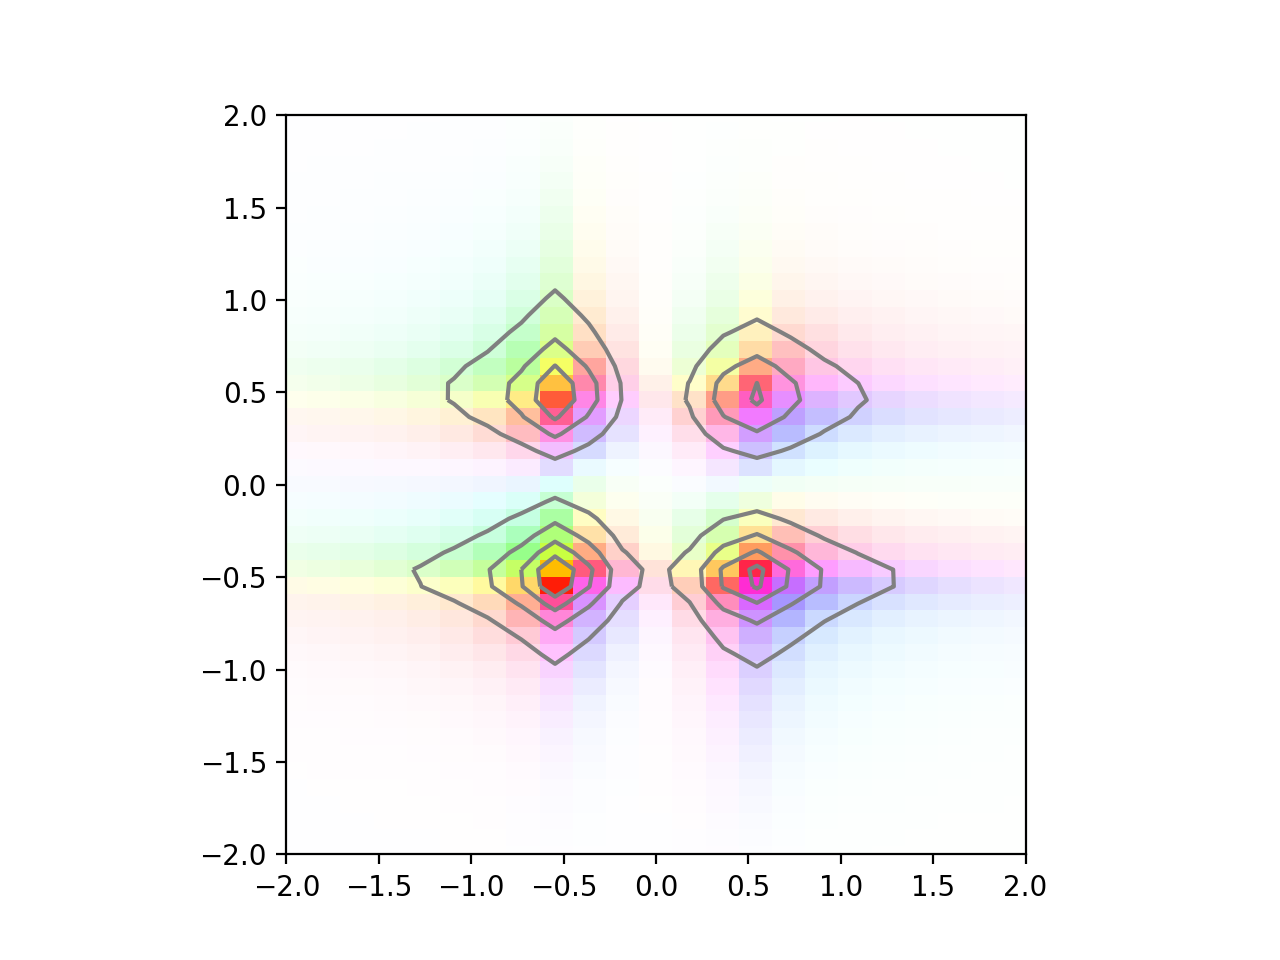

None


(-2, 2)

In [43]:
T_index = 0
print('2DPE signal at T = {:.2f} $\omega_0^{{-1}}$'.format(T[T_index]))
ufss.signals.plot2D(wtau,tdpe.w,ft_signal[:,T_index,:],part='complex',
                    contour_levels=[0.2,0.4,0.6,0.8],
                    contour_colormap=None,
                    contour_colors='gray',
                    colorbar=False)
plt.xlim([-2,2])
plt.ylim([-2,2])

TA signal


<IPython.core.display.Javascript object>


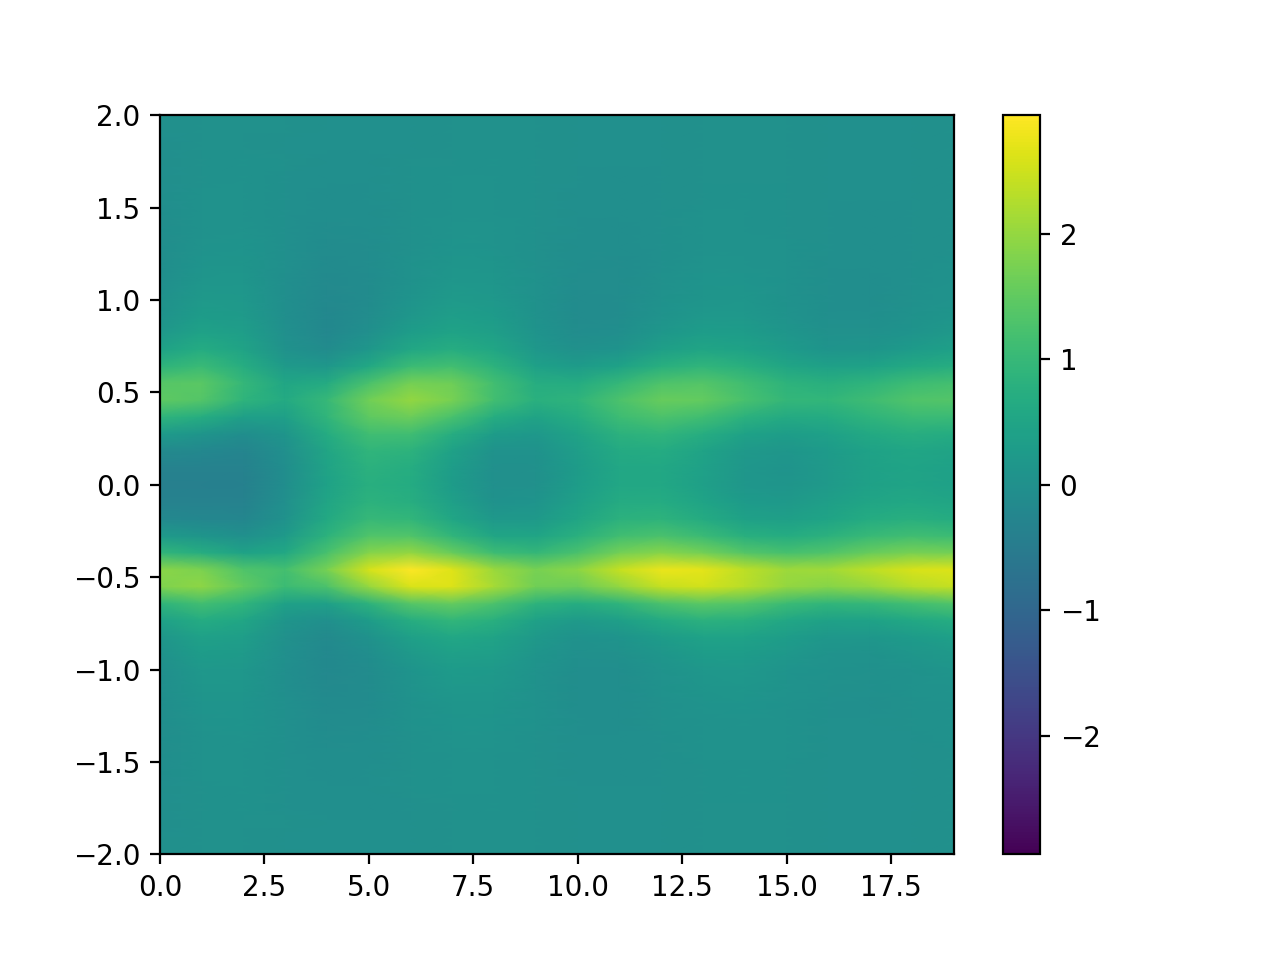

(-2, 2)

In [44]:
print('TA signal')
ufss.signals.plot2D(T,tdpe.w,signal[0,:,:],part='real',colormap='viridis')
#plt.xlim([-2,2])
plt.ylim([-2,2])

Integrated TA signal


<IPython.core.display.Javascript object>


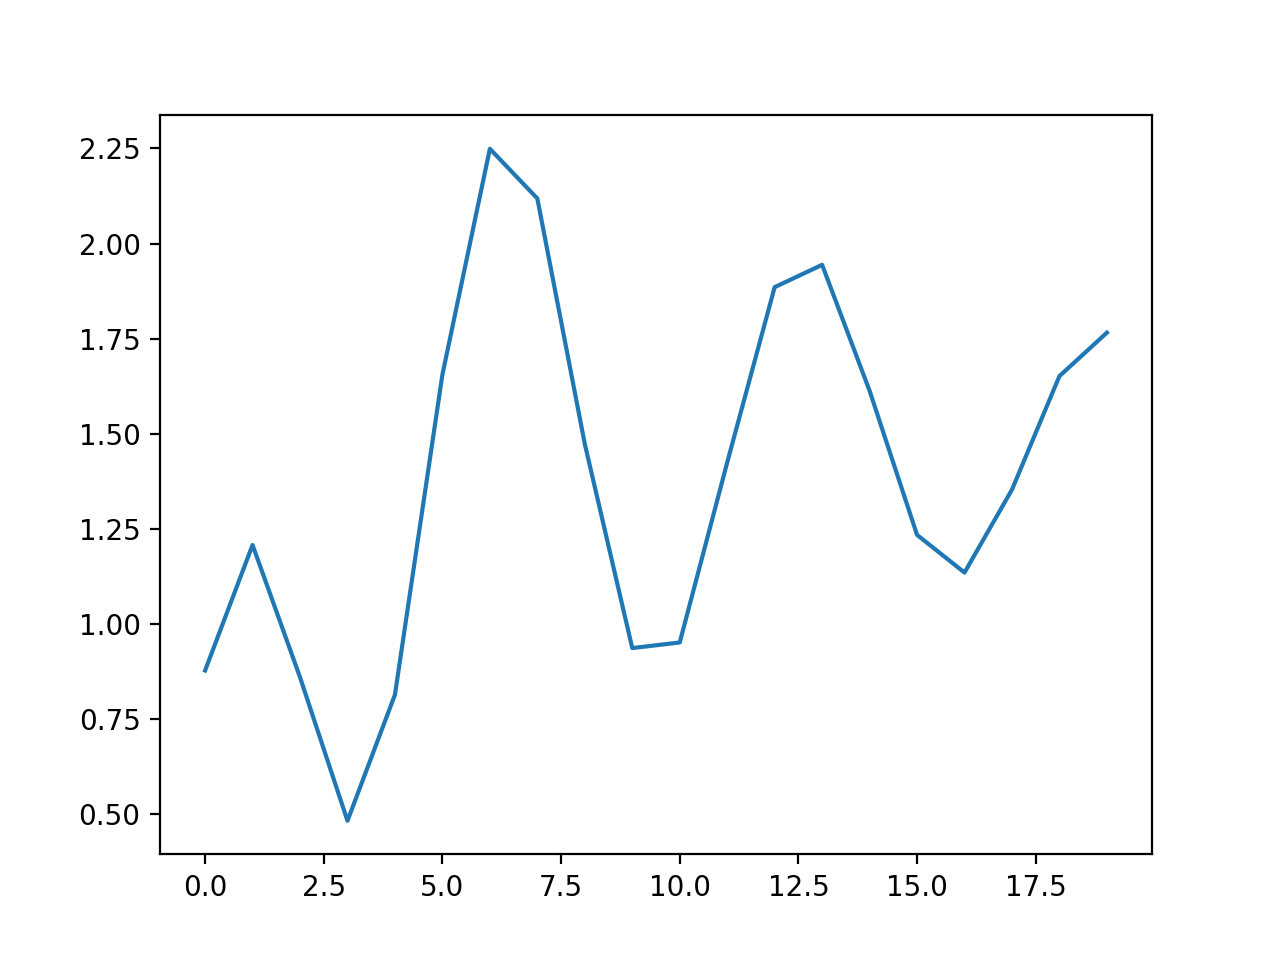

In [45]:
print('Integrated TA signal')
plt.figure()
plt.plot(T,np.trapz(np.real(signal[0,:,:]),x=tdpe.w,axis=-1))

In [46]:
# isotropic averaging is included for 4-wave mixing signals only
# all pulses have parallel polarization
iso = ufss.signals.FWMIsotropicAverage(tdpe,['x','x','x','x'])
sig_par = iso.averaged_signal(return_signal=True)

In [47]:
wtau, ft_sig_par = ufss.signals.SignalProcessing.ft1D(tau,sig_par,axis=0)

Isotropically Averaged 2DPE signal at T = 2.00 $\omega_0^{-1}$


<IPython.core.display.Javascript object>


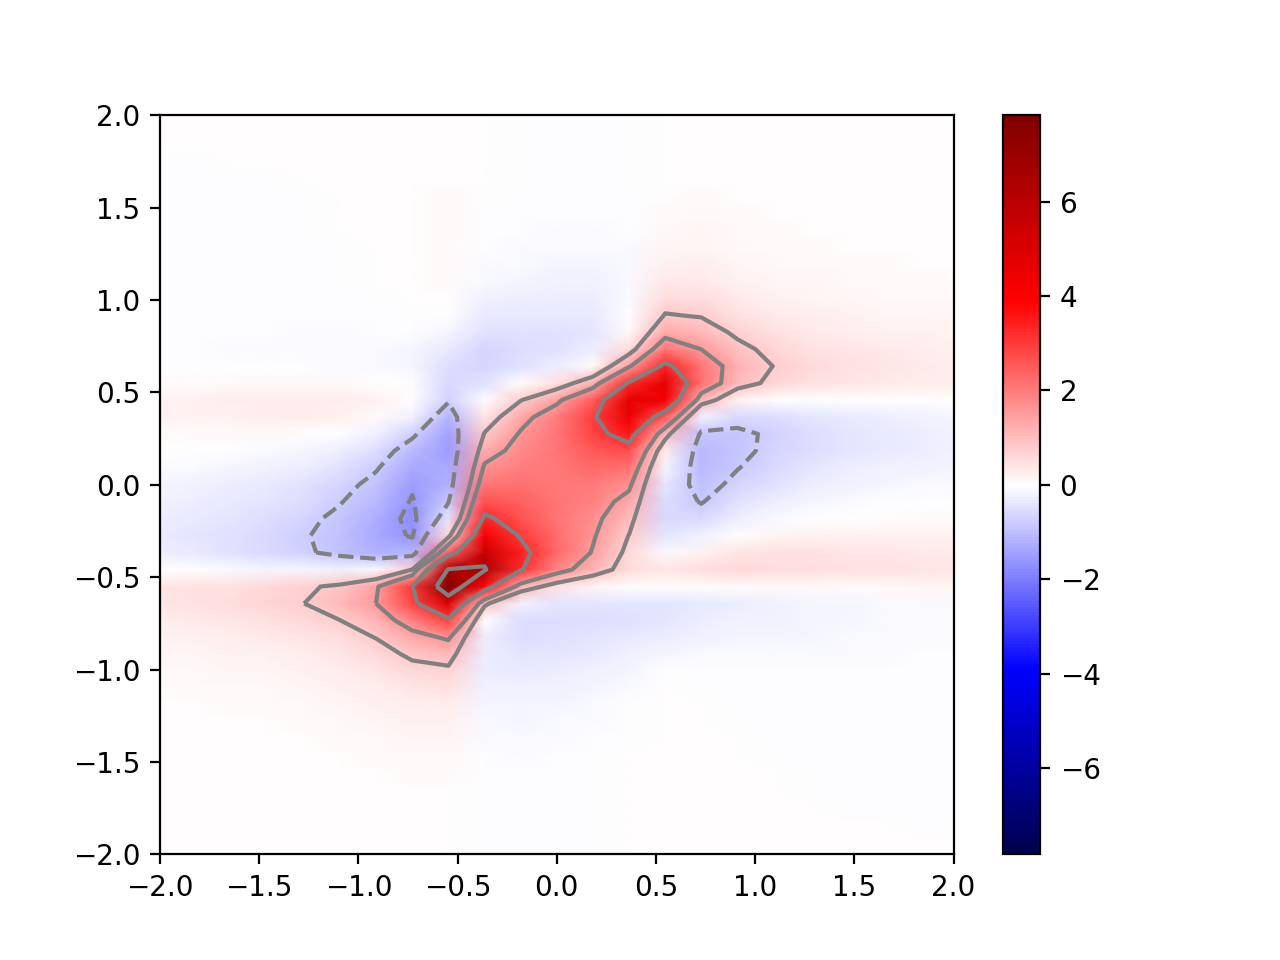

(-2, 2)

In [72]:
T_index = 2
print('Isotropically Averaged 2DPE signal at T = {:.2f} $\omega_0^{{-1}}$'.format(T[T_index]))
ufss.signals.plot2D(wtau,tdpe.w,ft_sig_par[:,T_index,:],part='real',
                    contour_levels=[-0.8,-0.4,-0.2,-0.1,0.1,0.2,0.4,0.8],
                   contour_colormap=None,
                   contour_colors='grey')
plt.xlim([-2,2])
plt.ylim([-2,2])

In [49]:
# 3rd pulse and local oscillator are crossed with respect to first two pulses
iso = ufss.signals.FWMIsotropicAverage(tdpe,['x','x','y','y'])
sig_per = iso.averaged_signal(return_signal=True)

In [50]:
wtau, ft_sig_per = ufss.signals.SignalProcessing.ft1D(tau,sig_per,axis=0)

Isotropically Averaged 2DPE signal at T = 0.00 $\omega_0^{-1}$


<IPython.core.display.Javascript object>


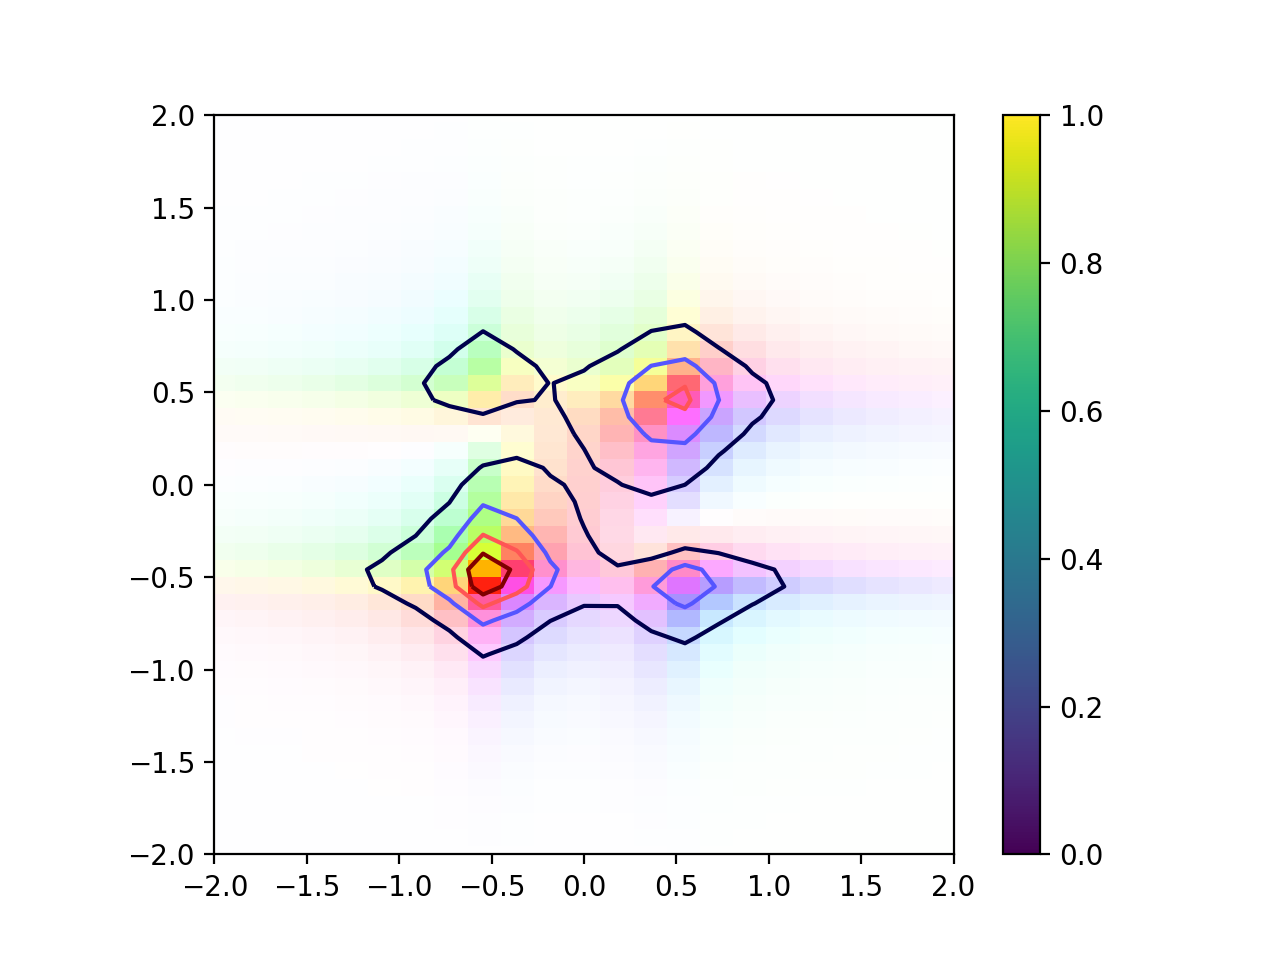

None


(-2, 2)

In [73]:
T_index = 0
print('Isotropically Averaged 2DPE signal at T = {:.2f} $\omega_0^{{-1}}$'.format(T[T_index]))
ufss.signals.plot2D(wtau,tdpe.w,ft_sig_per[:,T_index,:],part='complex',contour_levels=[0.2,0.4,0.6,0.8])
plt.xlim([-2,2])
plt.ylim([-2,2])

## Compare TA signal to RKE (calculating the full 2DPE using RKE would take about an hour and a half)

In [47]:
rke_ta = ufss.RKE_DensityMatrices(os.path.join(open_folder,'open'),detection_type='complex_polarization')
# set electric field shape
M = 801 #should be odd
Delta = 10
t = np.linspace(-Delta/2,Delta/2,num=M)
pulse_shape = ufss.efield_shapes.gaussian
sigma = 1
ef = pulse_shape(t,sigma)
rke_ta.set_efields([t,t,t],[ef,ef,ef],[0,0,0],[(1,1),(1,0)])
rke_ta.set_polarization_sequence(['x','x','x','x'])
rke_ta.set_t(0.2,dt=0.5)

T = np.arange(0,20)*np.pi/2

rke_ta.set_pulse_delays([T])

RKE_sparse_mu_flag False


In [ ]:
rke_signal = rke_ta.calculate_signal_all_delays()
rke_ta.save('RKE_TA',['T'])

In [ ]:
print('Time to calculate TA in s',rke_ta.calculation_time)
print('Estimated time to calculate 2DPE in s',rke_ta.calculation_time*tdpe.all_pulse_delays[0].size)

In [17]:
def L2_norm(s1,s2):
    return np.sqrt(np.sum(np.abs(s1-s2)**2)/np.sum(np.abs(s2)**2))

In [34]:
uf2_ta_signal = signal[0,:,:] # TA is the tau = 0 2DPE signal
L2_norm(rke_signal[:,:],signal[0,:,:])

0.00664899616529726